In [14]:
# library imports
import numpy as np
import pandas as pd
import pyflux as pf

# just for jupyter notebooks plot size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
# helper function, generate lagged datasets for testing on vintages
def gen_lagged_data(metadata, data, last_date, lag):
    # only go up to the last date
    lagged_data = data.loc[data.date <= last_date, :].reset_index(drop=True)
    for col in lagged_data.columns[1:]:
        pub_lag = metadata.loc[metadata.series == col, "months_lag"].values[0] # publication lag of this particular variable
        # go back as far as needed for the pub_lag of the variable, then + the lag (so -2 for 2 months back), also -1 because 0 lag means in month, last month data available, not current month in
        lagged_data.loc[(len(lagged_data) - pub_lag + lag - 1) :, col] = np.nan

    return lagged_data

# helper function, flatten a dataset for methods that don't do timeseries, extra columns for each lag
def flatten_data(data, target_variable, n_lags):
    flattened_data = data.loc[~pd.isna(data[target_variable]), :]
    orig_index = flattened_data.index
    for i in range(1, n_lags + 1):
        lagged_indices = orig_index - i
        lagged_indices = lagged_indices[lagged_indices >= 0]
        tmp = data.loc[lagged_indices, :]
        tmp.date = tmp.date + pd.DateOffset(months=i)
        tmp = tmp.drop([target_variable], axis=1)
        tmp.columns = [j + "_" + str(i) if j != "date" else j for j in tmp.columns]
        flattened_data = flattened_data.merge(tmp, how="left", on="date")

    return flattened_data

# helper function fill missings in a dataset with the mean from the training set
def mean_fill_dataset(training, test):
    mean_dict = {}
    for col in training.columns[1:]:
        mean_dict[col] = np.nanmean(training[col])
    filled = test.copy()
    for col in training.columns[1:]:
        filled.loc[pd.isna(filled[col]), col] = mean_dict[col]
    return filled

# Data set up

In [3]:
# data read
data = pd.read_csv("../data/data_tf.csv", parse_dates=["date"])
metadata = pd.read_csv("../data/meta_data.csv")

# target variable = GDP
target_variable = "gdpc1"
target_lag = 1 # GDP published after completion of the next month

# which artificial lags to test the model on, equivalent to number of months ahead of and behind the target date (e.g. 2020-06-01 for Q2 2020)
lags = list(range(-2, 3))

# train and test dates
train_start_date = "1947-01-01"
train_end_date = "2004-12-01"
test_start_date = "2005-03-01"
test_end_date = "2010-12-01"

# train and test datasets
train = data.loc[(data.date >= train_start_date) & (data.date <= train_end_date), :].reset_index(drop=True)
test = data.loc[(data.date >= train_start_date) & (data.date <= test_end_date), :].reset_index(drop=True) # let test set data begin from training begin, data lag/time series for test sets can go back into the training data

Data should be a dataframe of seasonally adjusted growth rates with months in rows and quarterly variables in the last month of the quarter, with `np.nan`s for interquarter months.

In [4]:
data.tail()

,date,payems,gdpc1,cpiaucsl,unrate,houst,indpro,dspic96,cpilfesl,pcepilfe,pcepi,permit,ulcnfb,a261rx1q020sbea
896,2021-09-01,0.002570,0.005709,0.004124,-0.096154,-0.014622,-0.009759,-0.016185,0.002431,0.002405,0.003465,-0.078443,0.023111,0.014297
897,2021-10-01,0.004383,NaN,0.009433,-0.021277,0.001290,0.012333,-0.001650,0.005992,0.004427,0.006487,0.042245,NaN,NaN
898,2021-11-01,0.001677,NaN,0.007791,-0.086957,0.081186,0.007375,-0.001950,0.005346,0.004803,0.006266,0.038717,NaN,NaN
899,2021-12-01,0.001338,0.016791,0.004705,-0.071429,0.014303,-0.001024,-0.002285,0.005501,0.004981,0.004476,0.097845,NaN,NaN
900,2022-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Training the model
Because of how VAR models are estimated, similar to ARMA models, there is no model training per se, the model is fitted and n-step ahead forecasts are generated at each data vintage in the testing set. This gives the model a bit more training information than the other methodologies, but there is no workaround I am aware of to to generate estimates on the test set with information exclusively from the training set.

In [5]:
# not used for training, just determining which lags to drop (intra-quarter observations of quarterly variables, i.e. all NAs)
flattened_training = flatten_data(mean_fill_dataset(train, train), target_variable, 3).dropna(axis=0, how="any")
flattened_training = flattened_training.loc[flattened_training.date.dt.month.isin([3,6,9,12]),:].reset_index(drop=True) # only keep quarterly observations
nunique = flattened_training.drop(["date", target_variable], axis=1).nunique()
cols_to_drop = nunique[nunique == 1].index
flattened_training = flattened_training.drop(cols_to_drop, axis=1) # important for mean-filling from training set later

# Testing the model on artificial data vintages

In [6]:
# dates in the test set
dates = (
        pd.date_range(test_start_date, test_end_date, freq="3MS")
        .strftime("%Y-%m-%d")
        .tolist()
    )

# actual values
actuals = list(test.loc[test.date.isin(dates), target_variable].values)

In [7]:
pred_dict = {str(k): [] for k in lags}
for lag in lags:
    for date in dates:
        # the data available for this date at this artificial vintage
        flattened_test = gen_lagged_data(metadata, test, date, lag)

        # unique to VAR, shift GDP up one to be able to forecast
        # e.g. estimating Q3 2020, need to have GDP value from Q2 2020 there to be able to fit and estimate VAR model
        # so prediction will be for Q3 2020 using Q3 2020 data
        flattened_test[target_variable] = flattened_test[target_variable].shift(3)
        flattened_test.loc[flattened_test.date == date, target_variable] = np.nanmean(flattened_test[target_variable]) # make sure lagging process didn't introduce any NAs

        # get data in format necessary for model
        flattened_test = flatten_data(flattened_test, target_variable, 3)
        flattened_test = flattened_test.drop(cols_to_drop, axis=1)
        flattened_test = mean_fill_dataset(flattened_training, flattened_test)

        # fit model
        model = pf.VAR(data=flattened_test.drop(["date"], axis=1), lags=1, target=target_variable)
        model.fit()

        # get prediction
        output = model.predict(5)[target_variable].values[0]
        pred_dict[str(lag)] = pred_dict[str(lag)] + [output]

# Assess and visualize model performance

In [8]:
# table of RMSE by vintage
performance = pd.DataFrame(columns=["Vintage", "RMSE"])
for lag in lags:
    tmp = pd.DataFrame({
        "Vintage":lag,
        "RMSE":np.sqrt(np.mean((np.array(actuals) - np.array(pred_dict[str(lag)])) ** 2))
    }, index=[0])
    performance = performance.append(tmp).reset_index(drop=True)
performance.round(4)

,RMSE,Vintage
0,0.0085,-2
1,0.0075,-1
2,0.0065,0
3,0.0067,1
4,0.0036,2


''

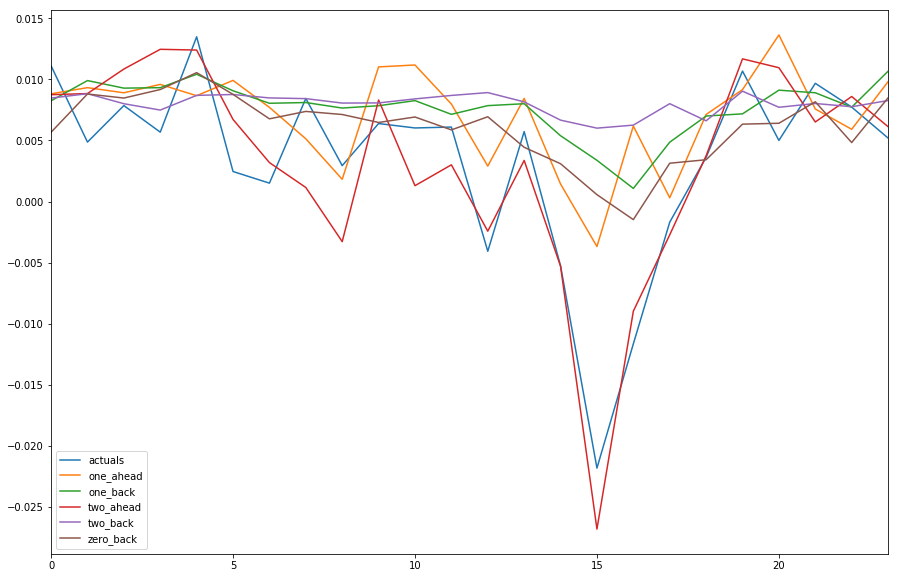

In [15]:
# plot of predictions vs actuals
pd.DataFrame({
    "actuals":actuals, 
    "two_back":pred_dict["-2"], 
    "one_back":pred_dict["-1"], 
    "zero_back":pred_dict["0"],
    "one_ahead":pred_dict["1"],
    "two_ahead":pred_dict["2"]}
).plot()
;

# Final model usage / getting predictions on new data
Say model selection is finished and the model is to now be used, i.e. used to get predictions on new data.

In [10]:
# the test data ends 2010-12-01, let's say we wanted to predict 2011-03-01
new_data = test.copy()

# the date we want predicted must be in the date, if it's not there it must be added
desired_date = pd.to_datetime("2011-03-01")

while desired_date > np.max(new_data.date):
    new_data.loc[len(new_data), "date"] = np.max(new_data.date) + pd.DateOffset(months=1)

# we can now confirm the date we want to forecast is in the dataframe, even if all values are missing
new_data.tail()

,date,payems,gdpc1,cpiaucsl,unrate,houst,indpro,dspic96,cpilfesl,pcepilfe,pcepi,permit,ulcnfb,a261rx1q020sbea
766,2010-11-01,0.000957,NaN,0.002534,0.042553,0.003683,0.000453,0.000845,0.001438,0.001300,0.001997,0.003584,NaN,NaN
767,2010-12-01,0.000551,0.005196,0.004017,-0.051020,-0.011009,0.009657,0.005819,0.000873,0.000206,0.002263,0.128571,0.001172,0.002461
768,2011-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
769,2011-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
770,2011-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# get data in format necessary for model
new_data[target_variable] = new_data[target_variable].shift(3)
new_data = flatten_data(new_data, target_variable, 3)
new_data = new_data.drop(cols_to_drop, axis=1)
new_data = mean_fill_dataset(new_data, new_data)

# fit model
model = pf.VAR(data=new_data.drop(["date"], axis=1), lags=1, target=target_variable)
model.fit();

In [12]:
# get prediction
model.predict(5)[target_variable].values[0]

0.007656946128833275